In [1]:
import pickle
import scipy.io
from PIL import Image, ImageDraw
import tensorflow as tf
import numpy
from skimage import color
import seaborn as sn
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from models import ICG_model_grid, ICG_model_att

In [2]:
IMAGE_ID = 0 # Random image from test2015  coco dataset
images_folder = '../data/images/test2015/'
feat_dir = '../data/res-feat/layer480/test2015/'

In [3]:
f = open('../data/coco_dict.pickle','rb') # Loading the vocabulary dictionary
coco_dict = pickle.load(f)
f.close()

coco_dict_rev = {} 
for key, value in coco_dict.items():
    coco_dict_rev[value] = key

In [4]:
hyperparameters = {'batch_size': 1, 'vocab_size': len(coco_dict), 'model': 'att_icg',
                   'word_emb_size': 512, 'feat_dim': 2048, 'dropout_keep_rate': 0.8,
                   'grid_feat_dim': 1024,'grid_size': 14, 'grid_emb_size': 512}

batch_size = hyperparameters['batch_size']
grid_feat_dim = hyperparameters['grid_feat_dim']
grid_size = hyperparameters['grid_size']

In [5]:
# Load the model and its variables based on the model type
if hyperparameters['model'] == 'grid_icg':
    features = {'grid_feat': tf.placeholder(tf.float32, [None, grid_feat_dim * grid_size * grid_size]),
                'pb': tf.placeholder(tf.float32, [None, 1000])}
    model = ICG_model_grid(features, hyperparameters, is_train=False)
    DIR = "../model/grid_icg"
    visual_concept_batch = model._visual_concept_batch
if hyperparameters['model'] == 'att_icg':
    features = {'grid_feat': tf.placeholder(tf.float32, [None, grid_feat_dim * grid_size * grid_size])}
    model = ICG_model_att(features, hyperparameters, is_train=False)
    DIR = "../model/att_icg"
    
ids = model._ids
attention_weights = model._all_att_weights
grid_feat_batch = model._grid_feat_batch


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Restoring parameters from ../model/att_icg/model-616600


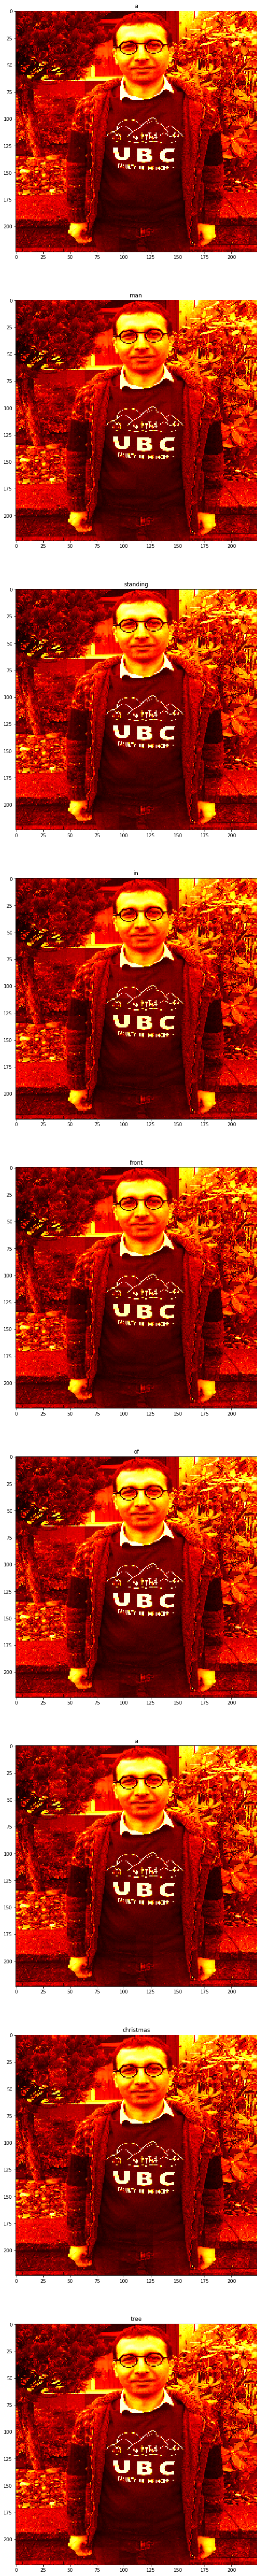

In [6]:
with tf.Session() as sess:
    
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    saver.restore(sess, tf.train.latest_checkpoint(DIR))
    
    # load fearures and probability of the image
    feats = []
    feat = scipy.io.loadmat(feat_dir + 'res_' + str(IMAGE_ID) + '.mat')
    feat = feat['feat'].astype(float)
    feat = numpy.reshape(feat, (-1), order = 'C')
    feats.append(feat)
    feats = numpy.asarray(feats, dtype=numpy.float32)

    
    if hyperparameters['model'] == 'grid_icg':
        probs = []
        prob = scipy.io.loadmat('../data/coco-vc/test2015/vc_' + str(IMAGE_ID) + '.mat')
        prob = prob['pb'].astype(float)
        prob = numpy.reshape(prob, (-1))
        probs.append(prob)
        probs = numpy.asarray(probs, dtype=numpy.float32)
        ids_val, attention_val = sess.run([ids,attention_weights], feed_dict = {grid_feat_batch: feats, visual_concept_batch: probs})
    if hyperparameters['model'] == 'att_icg':
        ids_val, attention_val = sess.run([ids,attention_weights], feed_dict = {grid_feat_batch: feats})
    
    # Sentence is the first sentence generated  
    sentence = []
    for j in range(ids_val[0, :, 0].shape[0]):
        sentence.append(coco_dict_rev[ids_val[0][j][0]])
    sentence_without_stop = []
    for value in sentence:
        if value != '<STOP>':
            sentence_without_stop.append(value)
        else:
            break 
    
    # Load the image
    img = cv2.imread(images_folder + 'COCO_test2015_' + "{:012d}".format(IMAGE_ID) + '.jpg')
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img_gray,(224,224))
    img = numpy.array(img) / 255.0

    fig, axs = plt.subplots(len(sentence_without_stop), 1, figsize=(100, 100))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel() 
    
    block_size = 224 // grid_size       
    for i in range(len(sentence_without_stop)):
        attention_val1 = attention_val[0][i][:,numpy.newaxis]
        attention_val2 = attention_val1.reshape((grid_size, grid_size))
        # temp is a 2D numpy array which is filled values stored in attention
        temp = numpy.zeros((224,224), dtype = numpy.float32)
        for row in range(grid_size):
            for col in range(grid_size):
                block = numpy.tile(attention_val2[row][col], (block_size , block_size))
                temp[row*block_size:(row+1)*block_size, col*block_size:(col+1)*block_size] = block

        combined_val = 0.8*temp + 0.2*img # Combine image and attentions 

        axs[i].imshow(combined_val, cmap='hot', interpolation='nearest')
        axs[i].set_title(sentence_without_stop[i])            